# Question
Basic Question:
Want to determine effects of power, precision, and ferocity on damage, in order to find the optimal stackup for most efficient leveling, where optimal stackup is defined as the combination of Power/Precision/Ferocity that results in the **lowest time required to kill a single mob**. 
- Given a certain ferocity and level, what's the optimal power/precision ratio that results in the least amount of average time to kill?
    - How does the variance of the time to kill change as the ratio of power/precision changes? 
- How does this optimal ratio change with regards to ferocity and level? 
- How does this optimal ratio change with regards to weapon choice? (i.e. the base damage range of your weapon, along with it's speed)?


Features we'll explore here:
- Power/Precision/Ferocity ratings
- Level

Features that affect damage, but that we won't explore here:
- Boons (like might)
- Class (like Ranger), which determines skills/boons
- Rotation & Weapons
- Weapon (normalizing this)
- Opponent's armor

# Assumptions
- Level of opponent and level of player are equal 
    - What happens if levels are not equal, in either direction?
- Health of opponent
- Constant armor quality (related to the amount of attribute points we have available to split between power, precision, and ferocity)

# Equations

## Damage done
Base strike damage is given by the following equation:

`Damage done = (Weapon strength) * Power * (skill-specific coefficient)/(target's Armor)`

`Weapon strength`: a uniformly distributed random number taken from the range of weapon strength of the equipped weapon. The weapon strength used for a skill will typically be that of the weapon associated with that skill; utility and elite skills are typically not affected by weapon strength and use a strike damage range based on the character's level. The weapon strength is also fixed for the duration of the skill, in particular pulsing aoes and channeled skills; although damage per hit is still affected by attributes, potions, sigils and other modifiers.<br>
`Power`: The current power attribute as listed on the Hero tab.<br>
`Skill coefficient`: Every skill has a unique coefficient used to calculate damage inflicted. Listed by the () after tool tip listed on wiki pages, not shown in-game however.<br>
`Target's Armor`: Not shown in-game for PvE targets.


## Modifiers
This base strike damage can then be modified by the following effects:

`Critical hits` increase amount of strike damage dealt. Critical hits default to 150% of base damage and this amount can be increased by the Ferocity player attribute. Critical Chance is governed by the Precision player attribute and flat bonuses such as the fury boon.<br>

`Critical Chance (%) = 5 + [ (Precision - Primary_attribute_base) / precision_per_1%_critical_chance ]`

`Glancing blows`, as caused by either level difference or weakness, only do 50% of regular damage and cannot critical hit.<br>
`Vulnerability` increases both types of damage dealt to target, but not falling damage.<br>
`Protection` decreases the damage received by a target by 33%<br>
Some champions or other enemies can become `Exposed`<br>
Other effects that increase the attacker's outgoing damage or the target's incoming damage, including those from upgrade components, traits, nourishment, etc.<br>

## Comments:
- Since target armor is directly proportional to `damage done`, we can remove that coefficient from the equation for our purposes here. 
- Since weapon strength is directly proportional to `damage done`, we can remove that coefficient from the equation for our purposes. 
- Then we have `strike damage` as being directly proportional to `power`. 

- SInce it's only the difference between `precision` and `Primary_attribute_base` that matters ultimately for the `critical change (%)`, we will combine these two terms into one called `adjusted_precision`. Ultimately, in order to calculate the exact precision you need to optimize your damage (for a given player level), you'll need the unadjusted `precision` value, along with the `Primary_attribute_base` value, but I can't find the table for of Precision's `primary_attribute_base` value for each level, so for now, I'll use the `adjusted_precision`. 
- #From [https://wiki.guildwars2.com/wiki/Armor], it appears that the ratio of the major/minor attribute points is always at 1.4 across quality designations (Basic, Fine, Masterwork, etc) for the triple attribute armor type. If we can assume that this ratio stays the same regardless of level, 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
# Tables
precision_per_crit_chance = {}
for i in range(4):
    start_level = i*20 + 1
    stop_level = i*20 + 20
    if i == 0:
        dic = {int(k):round(v, 1) for k,v in zip(np.linspace(start_level, stop_level, 20), np.linspace(1.1, 3.0, 20))}
    if i == 1:
        dic = {int(k):round(v, 1) for k,v in zip(np.linspace(start_level, stop_level, 20), np.linspace(3.2, 7.0, 20))}
    if i == 2:
        dic = {int(k):round(v, 1) for k,v in zip(np.linspace(start_level, stop_level, 20), np.linspace(7.3, 13.0, 20))}
    if i == 3:
        dic = {int(k):round(v, 1) for k,v in zip(np.linspace(start_level, stop_level, 20), np.linspace(13.4, 21, 20))}
    precision_per_crit_chance.update(dic)

In [62]:
# Level 
level = 80 # most information available about level 80

# weapon strength
weapon_strength = 1.0 # just whatever

# pct precision (the % of available attribute points spent in precision vs. power)
pct_split_vals = np.arange(0,101,1) / 100.0

# max adjusted precision 
max_adjusted_precision = (100 - 5) * precision_per_crit_chance[level] # precision required for 100% crit chance at any level

In [137]:
dmg = {}
for pct_split in range(len(pct_split_vals)):
    # adjusted precision calculation
    adjusted_precision = pct_split_vals[len(pct_split_vals) - pct_split - 1] * max_adjusted_precision

    # Power
    power = pct_split_vals[pct_split] * max_adjusted_precision
    
    # calculate damage
    crit_chance = min(5 + ((adjusted_precision) / precision_per_crit_chance[level]), 100)
    strike_dmg = power
    total_dmg = ((crit_chance/100.0 * (1.5)) * strike_dmg + strike_dmg) / 2 # expected critical damage, ferocity not included here
    dmg[pct_split] = [pct_split, adjusted_precision, power, crit_chance, strike_dmg, total_dmg]

df = pd.DataFrame.from_dict(dmg).T

df.columns = ['pct_split','adjusted_precision','power','crit_chance','strike_dmg','total_dmg']

df.head()

,pct_split,adjusted_precision,power,crit_chance,strike_dmg,total_dmg
0,0.0,1995.00,0.00,100.00,0.00,0.000000
1,1.0,1975.05,19.95,99.05,19.95,24.795356
2,2.0,1955.10,39.90,98.10,39.90,49.306425
3,3.0,1935.15,59.85,97.15,59.85,73.533206
4,4.0,1915.20,79.80,96.20,79.80,97.475700


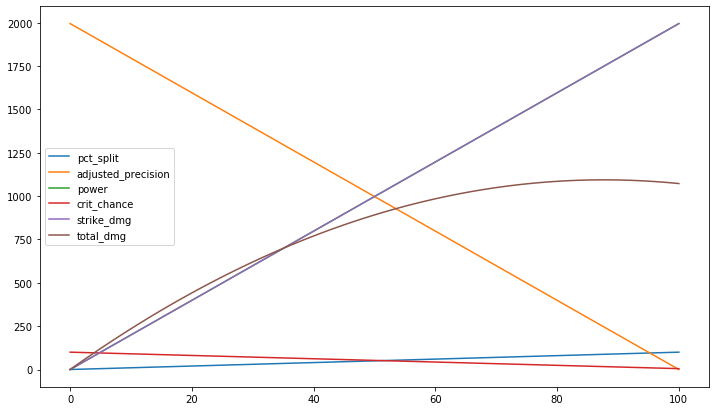

In [138]:
df.plot();

# Incorporate bootstrap sampling to calculate confidence intervals

In [132]:
samples = 101

dmg = {}
dmg_avg = {}
for pct_split in range(len(pct_split_vals)):
    # adjusted precision calculation
    adjusted_precision = pct_split_vals[len(pct_split_vals) - pct_split - 1] * max_adjusted_precision

    # Power
    power = pct_split_vals[pct_split] * max_adjusted_precision
    
    # calculate crit chance
    crit_chance = min(5 + ((adjusted_precision) / precision_per_crit_chance[level]), 100)
    
    # calculate strike damage
    strike_dmg = power * weapon_strength * np.random.uniform(0.9, 1.1, size=samples)
    
    # take samples=1000 samples of coin flips for whether crit landed or not
    crit_hits = np.random.binomial(1, crit_chance/100.0, size=samples).astype(bool)
    
    # calculate total damage
    total_dmg = [max(crit_hits[i].astype(int) * (1.5) * strike_dmg[i], (~crit_hits[i]).astype(int) * strike_dmg[i]) \
                 for i in range(samples)]

    # save
    dmg[pct_split] = total_dmg
    dmg_avg[pct_split] = [pct_split, 
                          adjusted_precision, 
                          power, 
                          crit_chance, 
                          np.mean(strike_dmg), 
                          np.mean(total_dmg), 
                          np.mean(total_dmg) - np.std(total_dmg), 
                          np.mean(total_dmg) + np.std(total_dmg)]

df = pd.DataFrame.from_dict(dmg)
df.index.name = 'attack_count'
df.head(10)

avg = pd.DataFrame.from_dict(dmg_avg).T
avg.columns = ['pct_split','adjusted_precision','power','crit_chance','strike_dmg','total_dmg', 'total_dmg + 1 SD', 'total_dmg - 1 SD']
avg = avg.set_index('pct_split')
# avg.head(10)

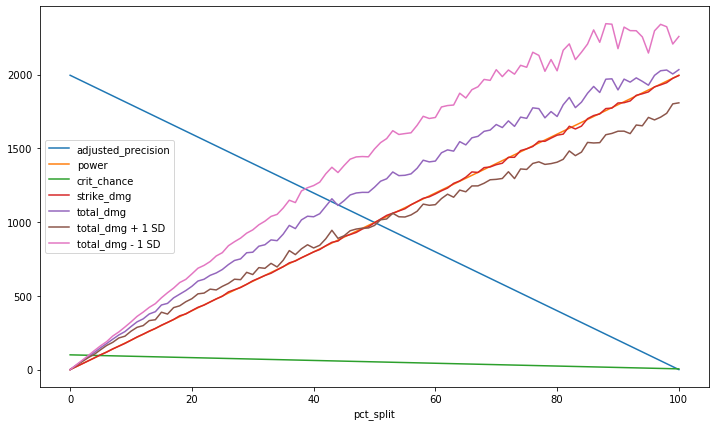

In [133]:
avg.plot(figsize=(12,7));

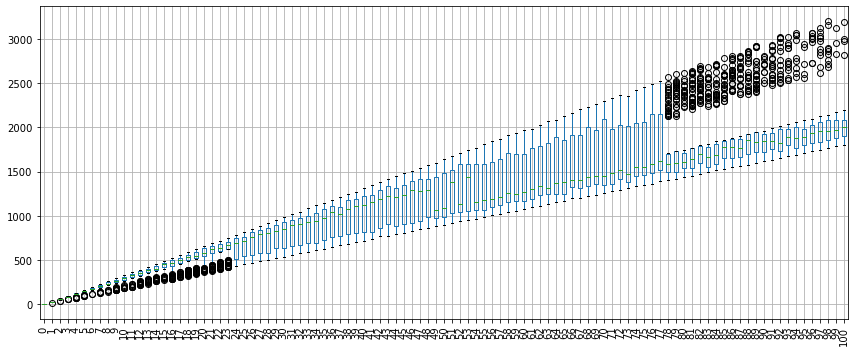

In [134]:
df.boxplot(figsize=(12,5));
plt.xticks(rotation=90);
plt.tight_layout()